<a href="https://colab.research.google.com/github/camulro/Aprendizaje-I-new/blob/main/nodulos_pulmon2_EJERCICIO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="#CA0032"><h1 align="left">**Redes convolucionales (CNNs)**</h1></font>

<font color="#6E6E6E"><h1 align="left">**Predicción de malignidad en nódulos pulmonares**</h1></font>

<h2 align="left">Manuel Sánchez-Montañés</h2>

<font color="#6E6E6E"><h2 align="left">manuel.smontanes@gmail.com</h2></font>

In [1]:
COLAB = True

In [2]:
if COLAB: #si usamos colab necesitamos instalar esta librería
    %tensorflow_version 1.x
    !pip install h5py==2.10.0

TensorFlow 1.x selected.
     |████████████████████████████████| 2.9 MB 5.4 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [3]:
# Base de datos y kernel de lectura y visualización de la base de datos obtenidos de:
#
# https://www.kaggle.com/kmader/lungnodemalignancy

import cv2 # pip install opencv-python
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
import urllib
from sklearn.metrics import confusion_matrix

%matplotlib inline

## **Carga de datos**

In [ ]:
!ls

sample_data


In [4]:
if COLAB:
    urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1Oxx1prDWV1e5vLeOAE7_jEdHPbVt6iil",
                               "all_patches.hdf5")

with h5py.File('all_patches.hdf5', 'r') as luna_h5:
    all_slices  = luna_h5['ct_slices'].value
    all_classes = luna_h5['slice_class'].value
    print('shape of all_slices:', all_slices.shape)
    print('shape of classes:   ', all_classes.shape)

shape of all_slices: (6691, 64, 64)
shape of classes:    (6691, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  import sys


In [5]:
  !ls -la

total 63120
drwxr-xr-x 1 root root     4096 Dec 30 10:35 .
drwxr-xr-x 1 root root     4096 Dec 30 10:29 ..
-rw-r--r-- 1 root root 64618370 Dec 30 10:35 all_patches.hdf5
drwxr-xr-x 4 root root     4096 Dec  3 14:33 .config
drwxr-xr-x 1 root root     4096 Dec  3 14:33 sample_data


In [6]:
np.unique(all_classes)

array([0., 1.])

In [7]:
def mi_montage2d(data):
    n = len(data)
    lado = int(np.ceil(np.sqrt(n)))
    alto1, ancho1 = data.shape[1:]
    aux = np.zeros((lado*alto1, lado*ancho1))
    for i,image in enumerate(data):
        row = i // lado
        col = i % lado
        aux[(row*alto1):((row+1)*alto1), (col*ancho1):((col+1)*ancho1)] = image
    return aux

In [8]:
def draw_borders(ax, ntiles, tile_width, tile_height, color='r'):
    
    aux1 = int(np.ceil(np.sqrt(ntiles)))
    
    npixels_y = tile_height*aux1
    for i in range(aux1-1):
        aux2 = (i+1)*tile_width - 0.5
        ax.plot([aux2, aux2], [0, npixels_y - 1], color)
        
    npixels_x = tile_width*aux1
    for i in range(aux1-1):
        aux2 = (i+1)*tile_height - 0.5
        ax.plot([0, npixels_x - 1], [aux2, aux2], color)

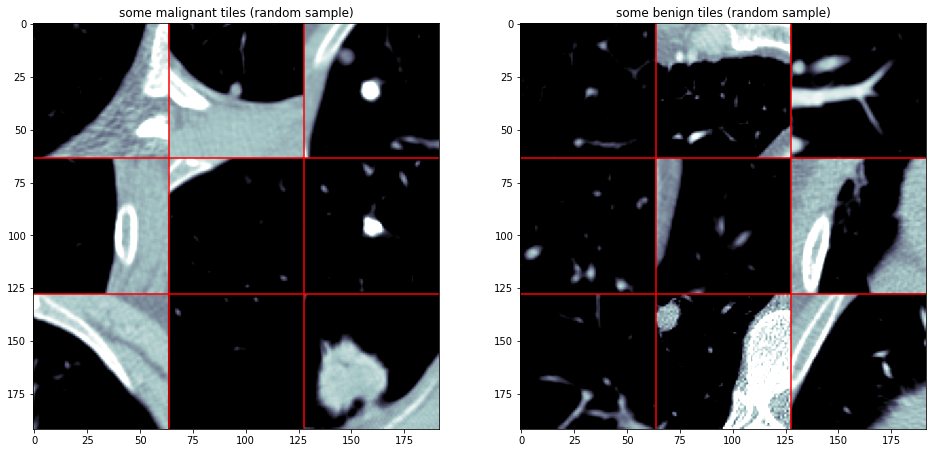

In [9]:
size = 9
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (16, 8))
plt_args = dict(cmap = 'bone', vmin = -600, vmax = 300)
#plt_args = dict(cmap = 'bwr', vmin = -600, vmax = 300)
ax1.imshow(mi_montage2d(all_slices[np.random.choice(np.where(all_classes==1)[0],size=size)]), **plt_args)
ax1.set_title('some malignant tiles (random sample)')
draw_borders(ax1, size, all_slices.shape[1], all_slices.shape[2], 'r')

ax2.imshow(mi_montage2d(all_slices[np.random.choice(np.where(all_classes==0)[0],size=size)]), **plt_args)
ax2.set_title('some benign tiles (random sample)')
draw_borders(ax2, size, all_slices.shape[1], all_slices.shape[2], 'r');

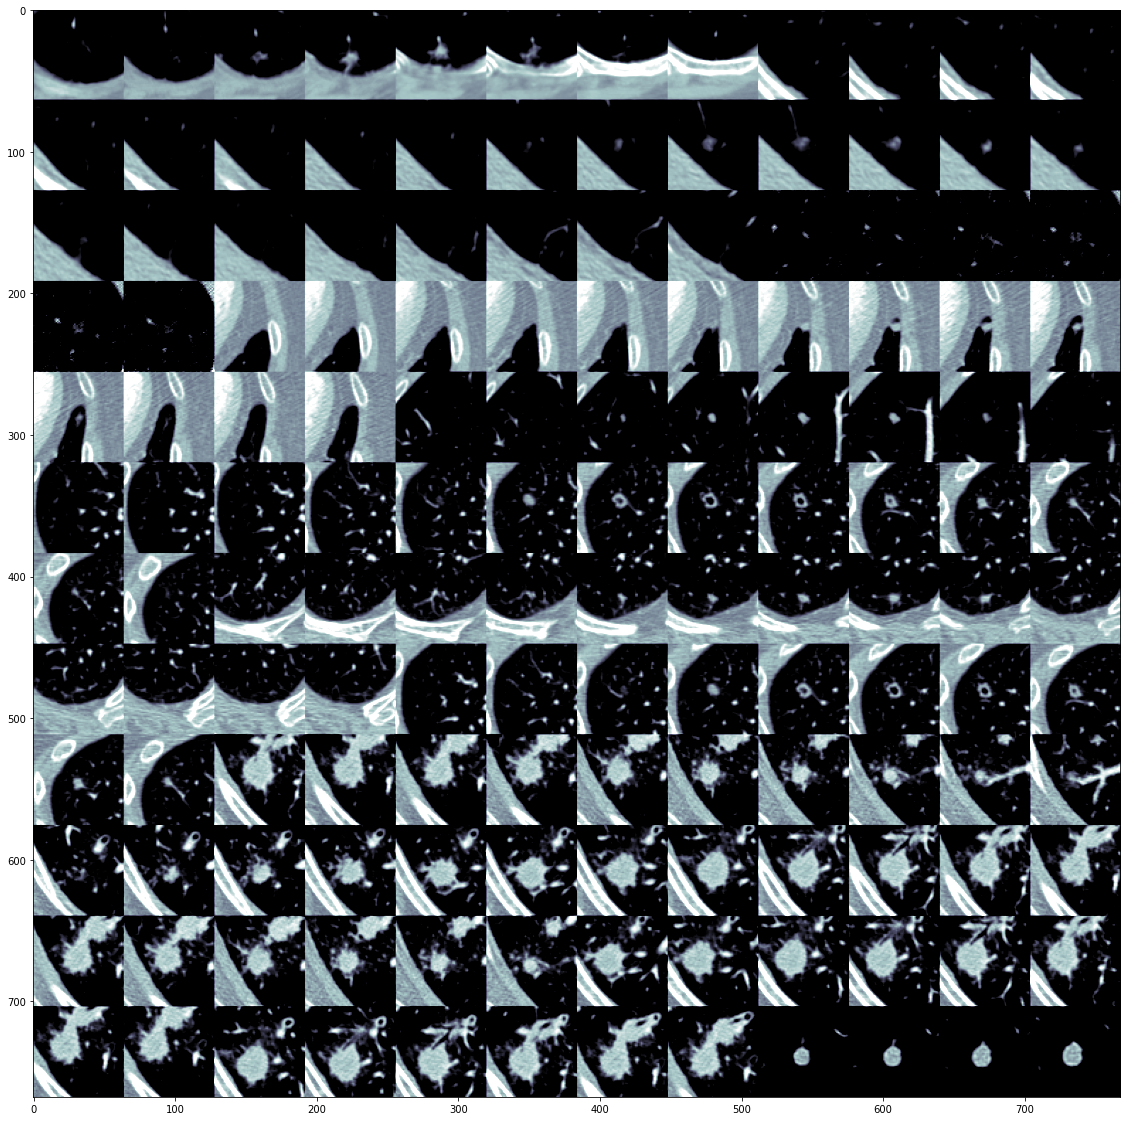

In [10]:
size = 144
plt.figure(figsize=(20,20))
plt_args = dict(cmap = 'bone', vmin = -600, vmax = 300)
#plt_args = dict(cmap = 'bwr', vmin = -600, vmax = 300)
plt.imshow(mi_montage2d(all_slices[:144]), **plt_args);#representa las 144 primeras imágenes del dataset

## **Partición y reformateo de datos**

Partiremos los datos en bases de datos de entrenamiento y validación. Recodificaremos la clase con la técnica one-hot.
Se estandarizarán los datos de la imagen.

In [11]:
all_slices.shape #imagenes 64x64

(6691, 64, 64)

In [12]:
all_slices[0].shape

(64, 64)

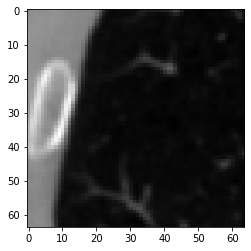

In [13]:
plt.imshow(all_slices[1000], cmap="gray");

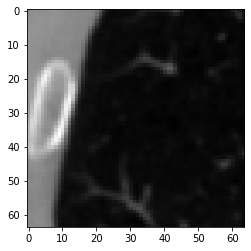

In [14]:
caso = 1000
plt.imshow(all_slices[caso], cmap="gray");

In [15]:
all_slices[caso,63,63]#cuanto vale el punto 63x63 en esa imágen

-926.0

In [16]:
print(all_slices.min(), all_slices.max(), all_slices.mean(), all_slices.std())

-3024.0 3071.0 -588.6012 407.58652


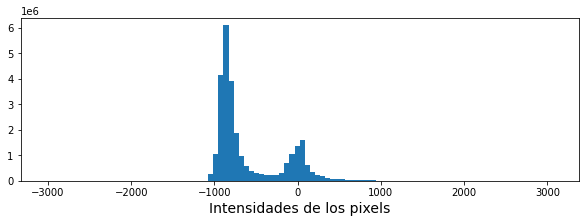

In [17]:
plt.figure(figsize=(10,3))
plt.hist(all_slices.reshape(-1), bins=100) #, density=True)
plt.xlabel('Intensidades de los pixels', fontsize=14)
plt.show()#es bimodal porque hay muchos píxeles claros y los otros son muy oscuros

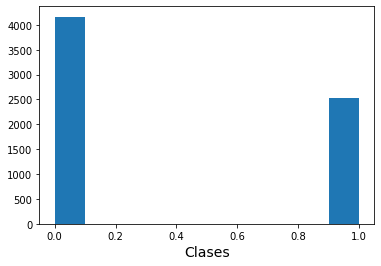

[0. 1.]
[4165 2526]


In [18]:
plt.hist(all_classes)
plt.xlabel('Clases', fontsize=14)
plt.show()

unicos, counts = np.unique(all_classes, return_counts=True)
print(unicos)
print(counts)

In [19]:
prioris_clases = counts / sum(counts)

In [22]:
print(prioris_clases.round(2))#benigno ocurre el 62%
#esto sirve para comparar el score de tu modelo, tiene que superar ese 62%

[0.62 0.38]


In [24]:
from keras.utils.np_utils import to_categorical

X_vec = np.expand_dims(all_slices,-1)#añade un canal de pegote porque keras necesita que haya al menos un canal
print(all_slices.shape)
X_vec.shape

(6691, 64, 64)


(6691, 64, 64, 1)

In [25]:
all_classes

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

In [27]:
y_vec = to_categorical(all_classes)#la clase 1 hace que la segunda columna sea 1 y la 0 que la primera sea 0
y_vec #luego tendré dos neuronas de salida en la red

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [28]:
# En este dataset están las imágenes ordenadas.
# Al principio hay unos pacientes, al final otros.
# Por ello partimos en orden, para que en test caigan otros pacientes que en
# training

def my_split_no_shuffle(X, y, test_size=0.3):#lo pasa en orden, en el fit del modelo ya mezcla los datos
    X0 = X[y[:,1] == 0]
    y0 = y[y[:,1] == 0]
    X1 = X[y[:,1] == 1]
    y1 = y[y[:,1] == 1]

    n = int(test_size*len(X0))
    X0_tr = X0[:-n]
    y0_tr = y0[:-n]
    X0_te = X0[-n:]
    y0_te = y0[-n:]

    n = int(test_size*len(X1))
    X1_tr = X1[:-n]
    y1_tr = y1[:-n]
    X1_te = X1[-n:]
    y1_te = y1[-n:]

    return np.vstack((X0_tr, X1_tr)), np.vstack((X0_te, X1_te)), np.vstack((y0_tr, y1_tr)), np.vstack((y0_te, y1_te))

In [29]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [30]:
X_train, X_test, y_train, y_test = my_split_no_shuffle(X_vec, y_vec, test_size = 0.25)#el primer 25% va a test y el resto a training

In [32]:
a = np.mean(X_train) # z-score (estandarización)
b = np.std(X_train)
#calcula promedio y std respecto de todos los ejes a la vez porque no especifica

X_train = (X_train - a) / b
X_test  = (X_test  - a) / b

X_train = sigmoid(X_train)
X_test  = sigmoid(X_test)

In [33]:
a, b

(0.4852597, 0.21043766)

In [34]:
X_train.shape

(5019, 64, 64, 1)

In [35]:
all_classes.shape, y_vec.shape

((6691, 1), (6691, 2))

In [36]:
import pickle#es importante grabarse los datos a pickle para luego en producción recuperar ese fichero y usar esos datos
with open('mi_fichero.pkl', 'wb') as f:
    pickle.dump({"media":a, "std":b}, f)

In [37]:
# En explotación:
with open('mi_fichero.pkl', 'rb') as f:
    normalizacion = pickle.load(f)

In [38]:
normalizacion

{'media': 0.4852597, 'std': 0.21043766}

In [39]:
a2 = normalizacion["media"]
b2 = normalizacion["std"]

print(a, b)
print(a2, b2)

0.4852597 0.21043766
0.4852597 0.21043766


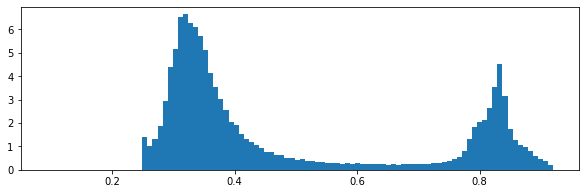

In [40]:
plt.figure(figsize=(10,3))
plt.hist(X_train.reshape(-1), bins=100, density=True)
plt.show()

Es importante escalar tanto las entradas como las salidas si haces regresión porque las redes neuronales trabajan mal con num muy grandes.

## **Modelo Dummy (baseline)**

In [44]:
X_train.shape#no puedes meter a sklearn datos que no tengan solo dos dimensiones

(5019, 64, 64, 1)

In [43]:
# Aplanado de las soluciones:
X_tr = X_train.reshape((len(X_train), -1))#quiero una matriz cuyo num de filas sea el num de ejemplos
X_te = X_test.reshape((len(X_test), -1))

print("X_train shape:", np.shape(X_train))
print("X_tr shape:   ", np.shape(X_tr))
print("X_test shape: ", np.shape(X_test))
print("X_te shape:   ", np.shape(X_te))

X_train shape: (5019, 64, 64, 1)
X_tr shape:    (5019, 4096)
X_test shape:  (1672, 64, 64, 1)
X_te shape:    (1672, 4096)


In [41]:
np.shape(y_train)

(5019, 2)

In [45]:
from sklearn.dummy import DummyClassifier

clf = DummyClassifier(strategy="most_frequent")
clf.fit(X_tr, np.argmax(y_train,1))
print('Train accuracy:', clf.score(X_tr, np.argmax(y_train,1)))
print('Test accuracy :', clf.score(X_te, np.argmax(y_test,1)))

Train accuracy: 0.6224347479577605
Test accuracy : 0.6226076555023924


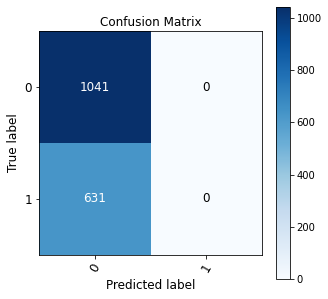

In [46]:
try:
    from scikitplot.metrics import plot_confusion_matrix
except:
    !pip install scikit-plot
    from scikitplot.metrics import plot_confusion_matrix

plot_confusion_matrix(y_test.argmax(1), clf.predict(X_te),
                      x_tick_rotation=60, figsize=(5,5),
                      text_fontsize='large');

El cuadro azul claro es el falso negativo, el peor error de medicina.


              precision    recall  f1-score   support

           0       0.62      1.00      0.77      1041
           1       0.00      0.00      0.00       631

    accuracy                           0.62      1672
   macro avg       0.31      0.50      0.38      1672
weighted avg       0.39      0.62      0.48      1672



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


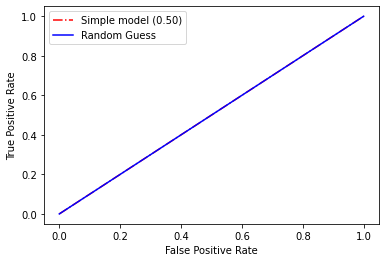

In [47]:
from sklearn.metrics import classification_report, roc_curve, auc

print('')
print(classification_report(np.argmax(y_test,1),
                            clf.predict(X_te)))

fpr, tpr, thresholds = roc_curve(np.argmax(y_test, 1), clf.predict_proba(X_te)[:,1])
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'Simple model (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend()
plt.show()

## **Modelo shallow: regresión logística**

In [48]:
X_train.shape

(5019, 64, 64, 1)

In [49]:
y_train[:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [50]:
X_tr.shape

(5019, 4096)

In [51]:
from sklearn.linear_model import LogisticRegression

model2 = LogisticRegression(C=0.01, penalty="l1", max_iter=500, solver="liblinear")
#por defecto pone l2, l1 es más agresivo. Para usar l1 tengo que cambiar el solver a ese(algoritmo de optimización)
model2.fit(X_tr, np.argmax(y_train,1))

LogisticRegression(C=0.01, max_iter=500, penalty='l1', solver='liblinear')

In [52]:
print('Train accuracy:', model2.score(X_tr, np.argmax(y_train,1)))
print('Test accuracy :', model2.score(X_te, np.argmax(y_test,1)))
#ahora está balanceado y mejora a lo obtenido en el dummie

Train accuracy: 0.6224347479577605
Test accuracy : 0.6226076555023924


In [53]:
np.argmax(y_test,1)

array([0, 0, 0, ..., 1, 1, 1])

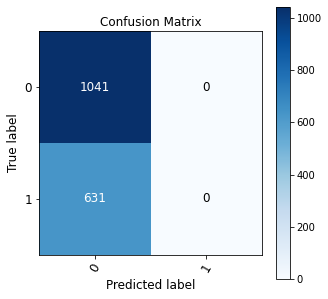

In [54]:
plot_confusion_matrix(y_test.argmax(1), model2.predict(X_te),
                      x_tick_rotation=60, figsize=(5,5),
                      text_fontsize='large');


              precision    recall  f1-score   support

           0       0.62      1.00      0.77      1041
           1       0.00      0.00      0.00       631

    accuracy                           0.62      1672
   macro avg       0.31      0.50      0.38      1672
weighted avg       0.39      0.62      0.48      1672



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


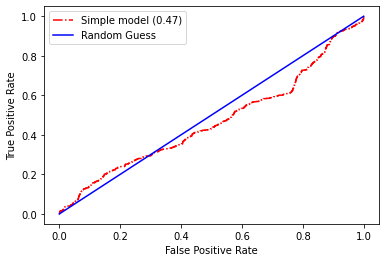

In [55]:
from sklearn.metrics import classification_report, roc_curve, auc

print('')
print(classification_report(np.argmax(y_test,1),
                            model2.predict(X_te)))

fpr, tpr, thresholds = roc_curve(np.argmax(y_test, 1), model2.predict_proba(X_te)[:,1])
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'Simple model (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend();

Para que la curva roc sea perfecta tiene que ser practicamente un cuadrado.

# **Definición de la arquitectura CNN**

Entrenaremos el modelo desde cero. Otra posibilidad es utilizar modelos pre entrenados (transfer learning).

In [57]:
# rellenar con imports de Keras

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [56]:
print("X_train shape:", np.shape(X_train))
print("X_test shape: ", np.shape(X_test))
print("y_train shape:", np.shape(y_train))
print("y_test shape: ", np.shape(y_test))

X_train shape: (5019, 64, 64, 1)
X_test shape:  (1672, 64, 64, 1)
y_train shape: (5019, 2)
y_test shape:  (1672, 2)


In [58]:
# Celdas para probar conceptos (convoluciones, maxpoolings)

In [59]:
model = Sequential()
model.add(Conv2D(filters=10, input_shape=X_train.shape[1:], padding="same",
                 kernel_size=(5,5), activation='relu'))
model.compile(loss='categorical_crossentropy', optimizer='adam')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [60]:
X_train.shape

(5019, 64, 64, 1)

In [61]:
X_train[caso].shape

(64, 64, 1)

In [62]:
X_train[caso:(caso+1)].shape

(1, 64, 64, 1)

In [63]:
pesos = model.layers[0].get_weights()
len(pesos)

2

In [64]:
print(pesos[0].shape)
print(pesos[1].shape)

(5, 5, 1, 10)
(10,)


In [65]:
pesos[0][:,:,0,0] = 0
pesos[0][0,:,0,0] = 1 # primera fila
pesos[0][1,:,0,0] = -1 # segunda fila
#remarca los píxeles asociados a bordes horizontales

In [66]:
model.layers[0].set_weights(pesos)

In [67]:
caso = 0
salida = model.predict(X_train[caso:(caso+1)])
salida.shape

(1, 64, 64, 10)

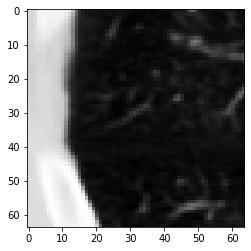

In [68]:
plt.imshow(X_train[caso][:,:,0], cmap="gray");

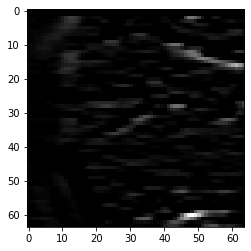

In [69]:
plt.imshow(salida[0][:,:,0], cmap="gray");

In [70]:
y_train[:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [71]:
y_test

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [72]:
X_tr.shape

(5019, 4096)

In [73]:
X_train.shape

(5019, 64, 64, 1)

In [74]:
input_shape = X_train.shape[1:]
input_shape

(64, 64, 1)

In [75]:
y_train.shape

(5019, 2)

In [76]:
num_classes = 2

In [77]:
input_shape

(64, 64, 1)

In [78]:
from keras.layers import GlobalAveragePooling2D, Dropout#globalaverage es como flatten
from keras.layers import BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop
from keras.regularizers import l2, l1 # penaliza la suma de los pesos al cuadrado
from keras.models import load_model, Model
from keras import backend as K
from IPython.display import clear_output
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [79]:
# Rellenar arquitectura de la red:
# filters: se mantiene o va subiendo en diferentes capas convolutivas
#kernel_size: se mantiene o va bajando en diferentes capas convolutivas

rate = 0.1

model = Sequential()
model.add(BatchNormalization(input_shape=input_shape))
model.add(Dropout(rate=rate, input_shape=input_shape))
model.add(Conv2D(filters=8, input_shape=input_shape, kernel_size=(5,5), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(rate=rate))
model.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(rate=rate))
model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(rate=rate))#se suele poner un dropout antes del "cuello de botella"
model.add(Flatten())
model.add(Dropout(rate=rate))#pone a 0 valores aleatorios
model.add(Dense(10, activation='relu', kernel_regularizer=l2(0.1)))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=1/1000),
              metrics=["accuracy"])


In [80]:
model.summary()#te dice cuantas capas tiene, num de parámetros...

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 64, 64, 1)         4         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 8)         208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 8)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 30, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 16)        3216      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 16)       

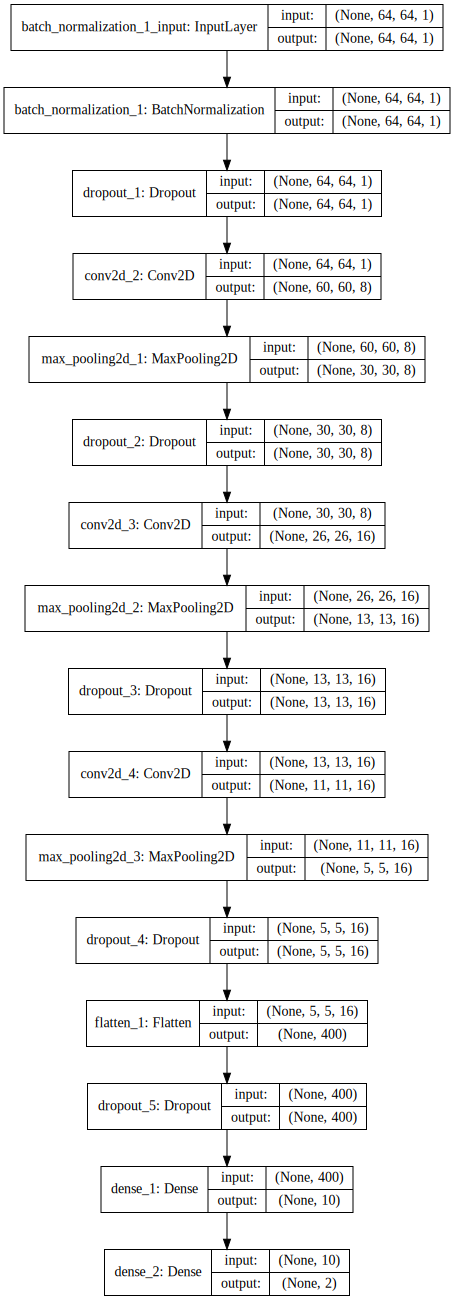

In [81]:
# graphviz
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True, dpi=72
                 ).create(prog='dot', format='svg'))

# **Entrenamiento del modelo CNN**

In [82]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [83]:
acum_tr_acc   = []
acum_val_acc  = []
acum_tr_loss  = []
acum_val_loss = []

In [84]:
LOAD_MODEL = False

Ntr = 4000

epochs = 100
batch_size = 16

#X_tr  = X_train[:Ntr]
#y_tr  = y_train[:Ntr]
#X_val = X_train[Ntr:]
#y_val = y_train[Ntr:]

X_tr, X_val, y_tr, y_val = my_split_no_shuffle(X_train, y_train, test_size=0.3)

In [85]:
# data augmentation:

train_datagen = ImageDataGenerator(
    dtype='float32',
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='mirror',
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

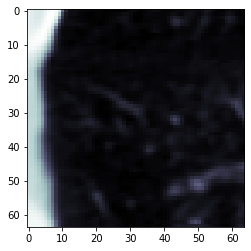

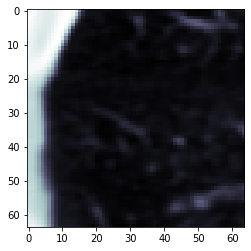

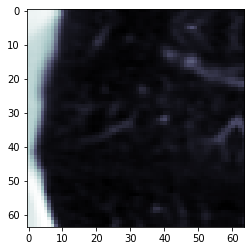

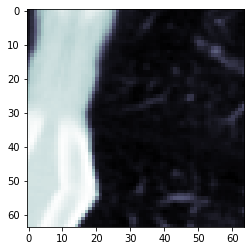

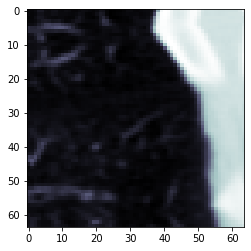

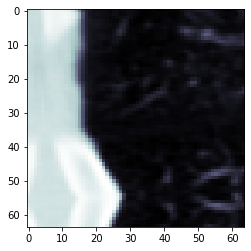

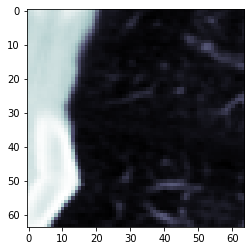

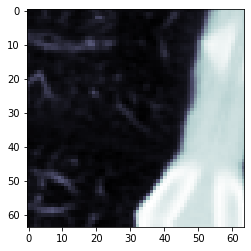

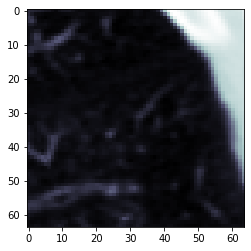

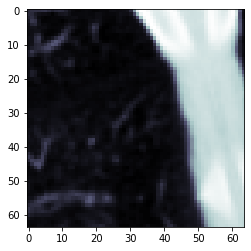

In [86]:
for _ in range(10):
    plt.imshow(train_datagen.flow(X_tr[:1])[0][0][:,:,0], cmap="bone")
    plt.show()

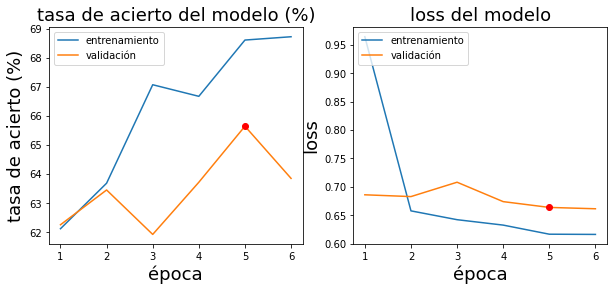

Train on 3514 samples, validate on 1505 samples
Epoch 1/1
3488/3514 [============================>.] - ETA: 0s - loss: 0.6131 - accuracy: 0.6869

KeyboardInterrupt: ignored

In [87]:
if not LOAD_MODEL:
    filepath="model_current_best_v2.h5"
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                                 save_best_only=True,
                                 mode='max') # graba sólo los que mejoran en validación
    callbacks_list = [checkpoint]
    
    for e in range(epochs):
        X_tr_aux, y_tr_aux = train_datagen.flow(X_tr, y=y_tr, batch_size=len(X_tr))[0]
        history = model.fit(X_tr_aux, y_tr_aux, 
                            batch_size=batch_size,
                            epochs=1,
                            callbacks=callbacks_list,
                            verbose=1,
                            validation_data=(X_val, y_val))
        
        acum_tr_acc.append(history.history['accuracy'][0])
        acum_val_acc.append(history.history['val_accuracy'][0])
        acum_tr_loss.append(history.history['loss'][0])
        acum_val_loss.append(history.history['val_loss'][0])
        
        if len(acum_tr_acc) > 1:
            clear_output()
            best_i = np.argmax(acum_val_acc)
            grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

El punto rojo es cuando ha funcionado mejor validación

In [88]:
!ls -la

total 63248
drwxr-xr-x 1 root root     4096 Dec 30 12:06 .
drwxr-xr-x 1 root root     4096 Dec 30 10:29 ..
-rw-r--r-- 1 root root 64618370 Dec 30 10:35 all_patches.hdf5
drwxr-xr-x 4 root root     4096 Dec  3 14:33 .config
-rw-r--r-- 1 root root      156 Dec 30 10:58 mi_fichero.pkl
-rw-r--r-- 1 root root   125512 Dec 30 12:07 model_current_best_v2.h5
drwxr-xr-x 1 root root     4096 Dec  3 14:33 sample_data


# **Resultados obtenidos por el modelo CNN**

In [89]:
if LOAD_MODEL:
    if COLAB:
        urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1UKpxwZsfPAp0kHywBucwWBtkxYAXy0lq",
                                   "modelo_entrenado.h5")
    model = load_model('./modelo_entrenado.h5')
else:
    model = load_model('model_current_best_v2.h5')

In [90]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 64, 64, 1)         4         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 8)         208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 8)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 30, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 16)        3216      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 16)       

In [91]:
score_tr = model.evaluate(X_tr, y_tr, verbose=0)
print('Train loss    :', score_tr[0])
print('Train accuracy:', score_tr[1])

score_val = model.evaluate(X_val, y_val, verbose=0)
print('Val loss    :', score_val[0])
print('Val accuracy:', score_val[1])

score_te = model.evaluate(X_test, y_test, verbose=0)
print('Test loss     :', score_te[0])
print('Test accuracy :', score_te[1])

Train loss    : 0.5833386869408831
Train accuracy: 0.7319294214248657
Val loss    : 0.6636949402153294
Val accuracy: 0.6564784049987793
Test loss     : 0.6309221381205691
Test accuracy : 0.6836124658584595


In [92]:
model.predict(X_test[:5])#con predict saco probabilidades, por eso pones un umbral a partir del que dar la alarma
#en skalearn para btener las prob tienes que usar predict_proba

array([[0.68659127, 0.31340873],
       [0.7178899 , 0.2821101 ],
       [0.7419424 , 0.2580576 ],
       [0.72440386, 0.2755962 ],
       [0.6835666 , 0.3164334 ]], dtype=float32)

In [93]:
umbral_decision_maligno = 0.1 # 0.4, 0.3, 0.2 ...

In [94]:
alarmas = 1*(model.predict(X_test)[:,1]>umbral_decision_maligno)
alarmas[:5]

array([1, 1, 1, 1, 1])

In [95]:
clases_test = y_test.argmax(1) # clase real test

In [96]:
confusion_matrix(clases_test, alarmas)

array([[   7, 1034],
       [   0,  631]])

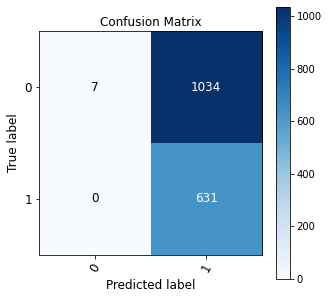

In [97]:
# en el siguiente cálculo y en adelante es equivalente
# a asumir que umbral_decision_maligno = 0.5
plot_confusion_matrix(y_test.argmax(1), alarmas,
                      x_tick_rotation=60, figsize=(5,5),
                      text_fontsize='large');

### ¿Cuál es el umbral óptimo si sé los costes de los errores?

In [98]:
prob_maligno = model.predict(X_val)[:,1]
prob_maligno

array([0.2904466 , 0.37494534, 0.29851195, ..., 0.4605724 , 0.41337842,
       0.24640855], dtype=float32)

In [99]:
y_val[:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [100]:
def analisis_costes(model, X, y,
                    clase_positiva, coste_falso_positivo, coste_falso_negativo):
    prob_positivo = model.predict(X)[:,clase_positiva]
    umbrales = sorted(np.unique(prob_positivo))
    coste_total = []
    n_positivos_en_alarmas = []
    n_positivos_fuera_de_alarmas = []
    n_negativos_en_alarmas = []
    costes = []
    coste_FP = coste_falso_positivo
    coste_FN = coste_falso_negativo

    for umbral in umbrales:
      aux = prob_positivo > umbral #array de booleanos
      n_positivos_en_alarmas.append(sum(y[aux,clase_positiva])) # aciertos en casos que son alarmas
      n_negativos_en_alarmas.append(sum(1-y[aux,clase_positiva])) # fallos en casos que son alarma, FALSOS POSITIVOS
      n_positivos_fuera_de_alarmas.append(sum(y[~aux,clase_positiva])) # FALSOS NEGATIVOS
      costes.append(coste_FP*n_negativos_en_alarmas[-1] + coste_FN*n_positivos_fuera_de_alarmas[-1])

    plt.plot(umbrales, n_positivos_en_alarmas, label="positivos que son alarmas")
    plt.plot(umbrales, n_negativos_en_alarmas, label="negativos que son alarmas")
    plt.plot(umbrales, n_positivos_fuera_de_alarmas, label="positivos que NO son alarmas")
    plt.xlabel("umbral alarma")

    plt.legend();
    plt.show()
    plt.plot(umbrales, costes, label="COSTE TOTAL")
    plt.legend()
    plt.xlabel("umbral alarma")
    plt.show()

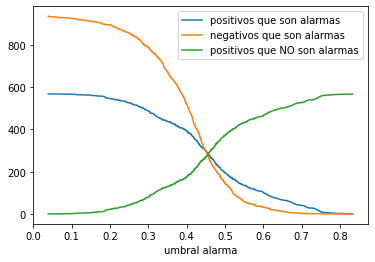

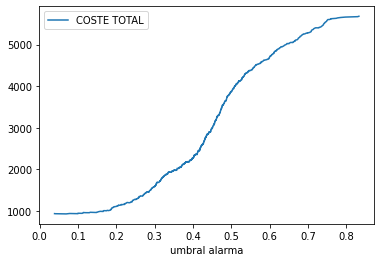

In [101]:
analisis_costes(model, X_val, y_val, clase_positiva=1, coste_falso_positivo=1, coste_falso_negativo=10)#dar un falso negativo se penaliza
#10 veces mas que un falso positivo

In [102]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba,1)
print('')
print(classification_report(clases_test, y_pred))


              precision    recall  f1-score   support

           0       0.70      0.87      0.77      1041
           1       0.63      0.38      0.48       631

    accuracy                           0.68      1672
   macro avg       0.67      0.62      0.63      1672
weighted avg       0.67      0.68      0.66      1672



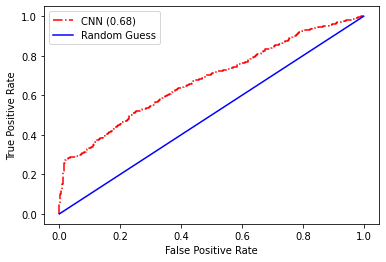

In [103]:
fpr, tpr, thresholds = roc_curve(clases_test, y_pred_proba[:,1])
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend();

# **Análisis de los pesos de la primera capa**

In [104]:
weights = model.get_weights()
print(np.shape(weights))
for i in range(len(weights)):
    print('shape of weights[%d]: ' % i, np.shape(weights[i]))

(14,)
shape of weights[0]:  (1,)
shape of weights[1]:  (1,)
shape of weights[2]:  (1,)
shape of weights[3]:  (1,)
shape of weights[4]:  (5, 5, 1, 8)
shape of weights[5]:  (8,)
shape of weights[6]:  (5, 5, 8, 16)
shape of weights[7]:  (16,)
shape of weights[8]:  (3, 3, 16, 16)
shape of weights[9]:  (16,)
shape of weights[10]:  (400, 10)
shape of weights[11]:  (10,)
shape of weights[12]:  (10, 2)
shape of weights[13]:  (2,)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1_input  (None, 64, 64, 1)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 1)         4         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 8)         208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 8)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 30, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 16)        3216

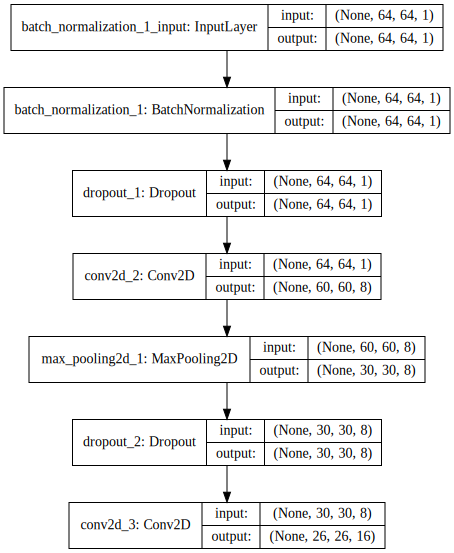

In [105]:
capa = 5 # 4
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[capa].output)
intermediate_layer_model.summary()
SVG(model_to_dot(intermediate_layer_model,show_shapes=True,dpi=72).create(prog='dot', format='svg'))

In [106]:
id_imagen = 2
imagen = X_test[id_imagen,:,:,0]
salidas_capa0 = intermediate_layer_model.predict(imagen.reshape([1,imagen.shape[0],
                                                                 imagen.shape[1],1]))

In [107]:
salidas_capa0.shape

(1, 26, 26, 16)

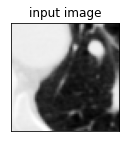

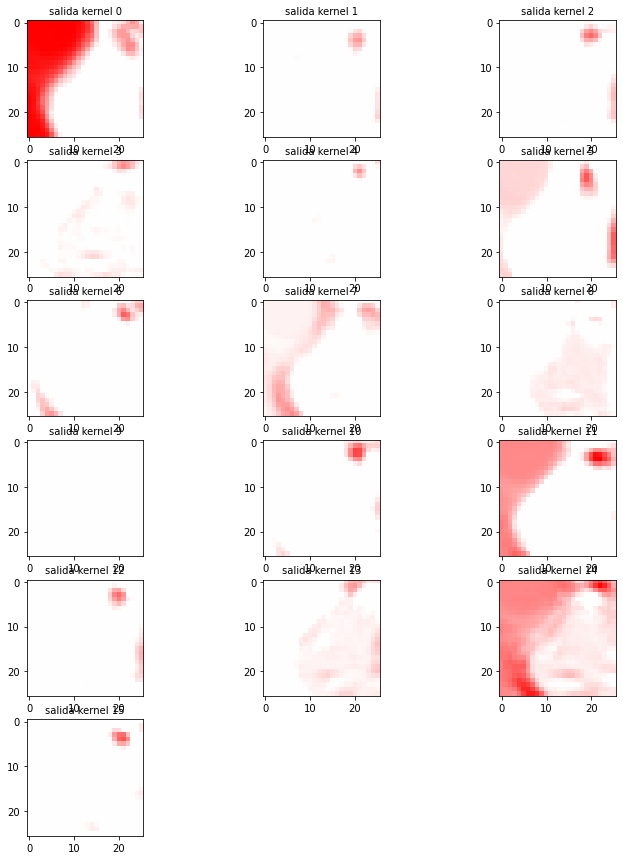

In [108]:
lado = 3
plt.figure(figsize=(2,2))
plt.imshow(imagen, cmap='gray')
plt.title('input image', size=12)
plt.xticks(())
plt.yticks(())
plt.show()

plt.subplots(lado,lado,figsize = (12, 15))

ma = abs(salidas_capa0).max()

columnas = 3
filas = int(np.ceil(salidas_capa0.shape[-1] / columnas))
for i in range(salidas_capa0.shape[-1]):
    plt.subplot(filas,columnas,i+1)
    plt.imshow(salidas_capa0[0,:,:,i], vmin=-ma, vmax=ma, cmap='bwr')
    plt.title('salida kernel %d' % i, fontsize=10)
plt.show()#que es lo que saca la neurona

### **¿A qué partes de la imagen de entrada es más sensible la salida de la red?**

### **GradCam:**

(de https://medium.com/analytics-vidhya/visualizing-activation-heatmaps-using-tensorflow-5bdba018f759)

1- Calcular para una imagen la salida del modelo y la salida de la última capa convolucional

2- Encuentrar la neurona de salida más activa (que es la que determina la clase predicha)

3- Calcular el gradiente de dicha neurona de salida con respecto a la última capa convolucional

3- Promediar y pesar esto con la salida de la última capa convolucional

4- Normalizar entre 0 y 1 para visualizar

5- Convertir a RGB y superponerla a la imagen original

Intentar detectar que zonas de la imagen son críticas en la convolución.
Los píxeles asociados a zonas que si las cambias cambia mas la salida son los más importantes para la clasificación.

**Funciones que calculan la sensibilidad de la salida a la entrada:**

In [111]:
def find_ind_last_conv2D(model):
    ind_last_conv2D_layer = None
    for i,x in enumerate(model.layers):
        if x.__class__.__name__ == "Conv2D":
            ind_last_conv2D_layer = i
    return ind_last_conv2D_layer

In [112]:
ind_last_conv2D_layer = find_ind_last_conv2D(model)
ind_last_conv2D_layer

8

In [113]:
model.layers[ind_last_conv2D_layer]

In [114]:
def show_heatmap(model, im, es_maligna):
    imag = np.reshape(im, (1, im.shape[0], im.shape[1], im.shape[2]))
        
    # This is the "benign" entry in the prediction vector
    output = model.output[:, 0]
    
    # The is the output feature map of the last convolutional layer
    last_conv_layer = model.layers[find_ind_last_conv2D(model)]
    
    # This is the gradient of the "benign" class with regard to
    # the output feature map of last convolutional layer
    grads = K.gradients(output, last_conv_layer.output)[0]
    
    # This is a vector where each entry
    # is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    # This function allows us to access the values of the quantities we just defined:
    # `pooled_grads` and the output feature map of the last convolutional layer
    # given a sample image
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    
    # These are the values of these two quantities, as Numpy arrays,
    # given our sample image
    pooled_grads_value, conv_layer_output_value = iterate([imag])
    
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the output of the model
    for i in range(conv_layer_output_value.shape[-1]):
        conv_layer_output_value[:,:,i] *= pooled_grads_value[i]
    
    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    plt.matshow(heatmap)
    plt.show()
    
    
    # We use cv2 to load the original image
    #img = cv2.imread(img_path)
    img = imag[0]
    
    img = np.zeros((im.shape[0],im.shape[1],3))
#    print(im.shape, imag.shape)
    for i in range(3):
        img[:,:,i] = imag[0,:,:,0]

    
    # We resize the heatmap to have the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # We convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    
    # We apply the heatmap to the original image
    #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)
    
    ##img = np.maximum(img, -2)
    ##img = np.minimum(img,  2)
    ##img = (img+2)/4;

    # 0.4 here is a heatmap intensity factor
    superimposed_img = heatmap * 0.2 / 255 + 0.8*img
    #print(heatmap.min(), heatmap.max(), heatmap.mean(), heatmap.std())
    #print(img.min(), img.max(), img.mean(), img.std())
    #print(superimposed_img.min(),  superimposed_img.max(),
    #      superimposed_img.mean(), superimposed_img.std())
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(img, vmin=0, vmax=1)
    plt.subplot(1,3,2)
    plt.imshow(heatmap, vmin=0, vmax=1)
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.imshow(superimposed_img, vmin=0, vmax=1)
    plt.show()
    #print(np.shape(imag))
    print("- Probabilidad clase maligna:", model.predict(imag)[0][1])
    print("-", "Clase real:", "maligna" if es_maligna else "benigna")
    print("\n\n\n")
    return heatmap, superimposed_img

**Visualización de mapas de sensibilidades (heatmaps) en varios ejemplos:**

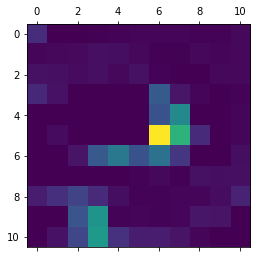

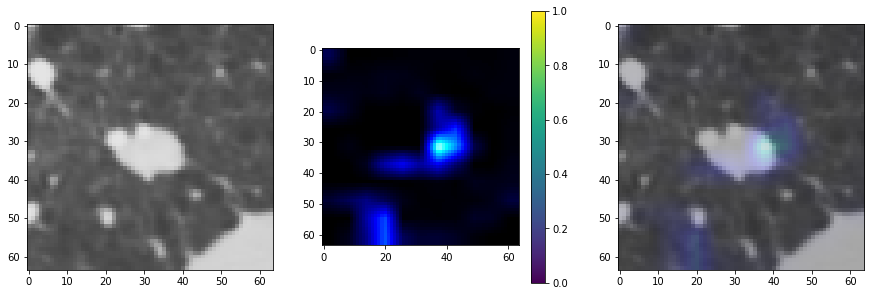

- Probabilidad clase maligna: 0.79021275
- Clase real: maligna






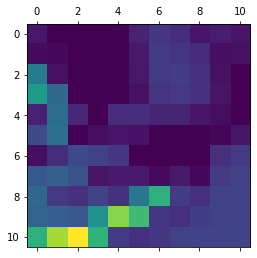

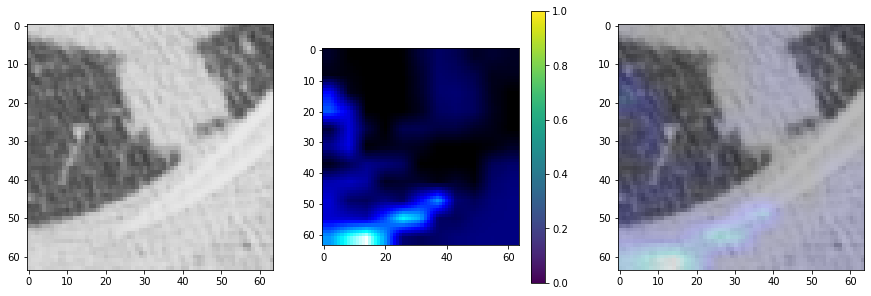

- Probabilidad clase maligna: 0.35272327
- Clase real: maligna






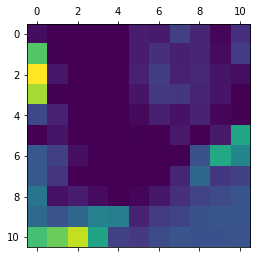

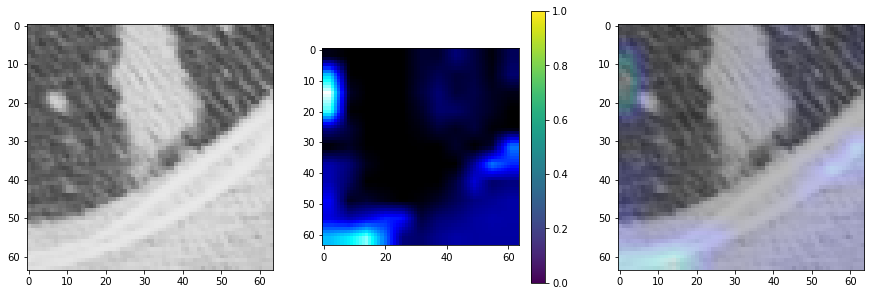

- Probabilidad clase maligna: 0.3557608
- Clase real: maligna






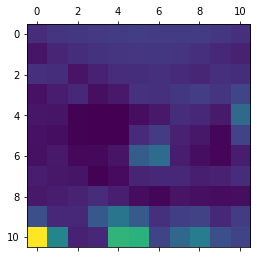

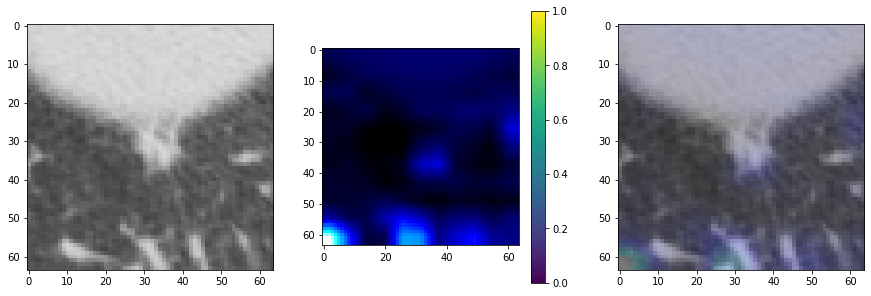

- Probabilidad clase maligna: 0.47534892
- Clase real: maligna






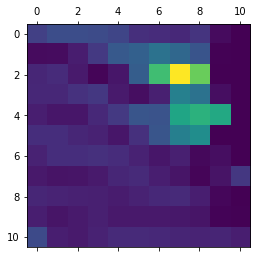

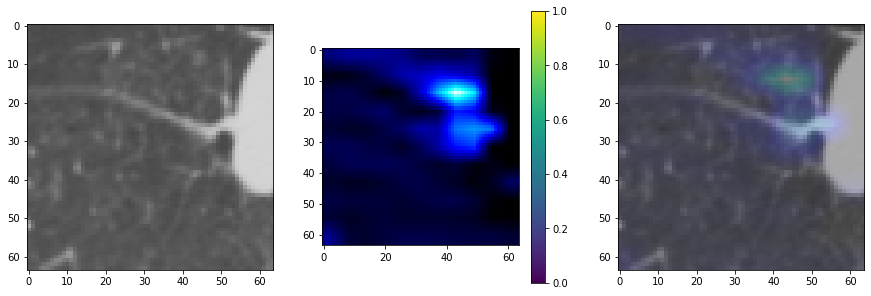

- Probabilidad clase maligna: 0.4199391
- Clase real: maligna






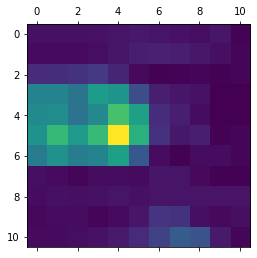

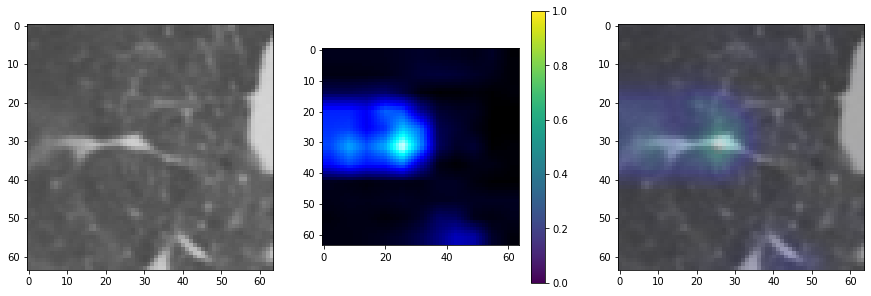

- Probabilidad clase maligna: 0.3076128
- Clase real: maligna






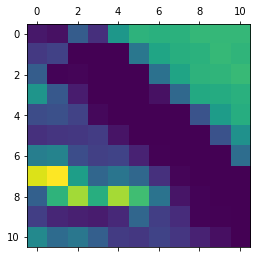

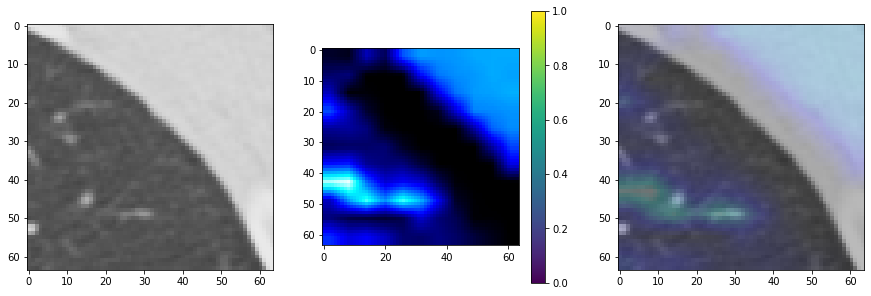

- Probabilidad clase maligna: 0.48521075
- Clase real: maligna






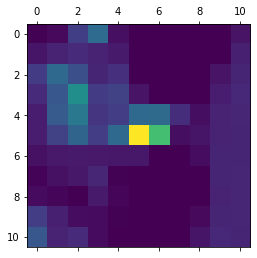

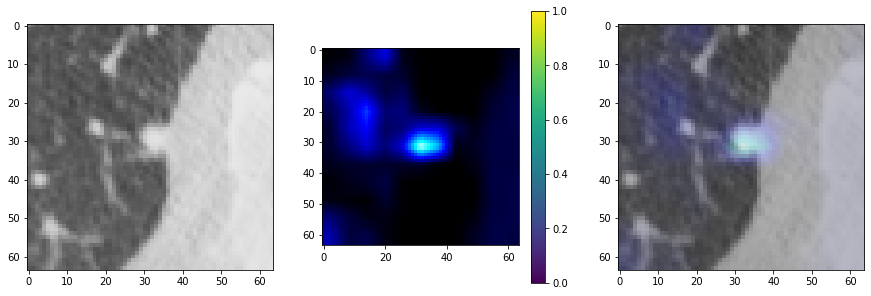

- Probabilidad clase maligna: 0.61050445
- Clase real: maligna






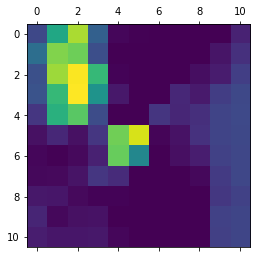

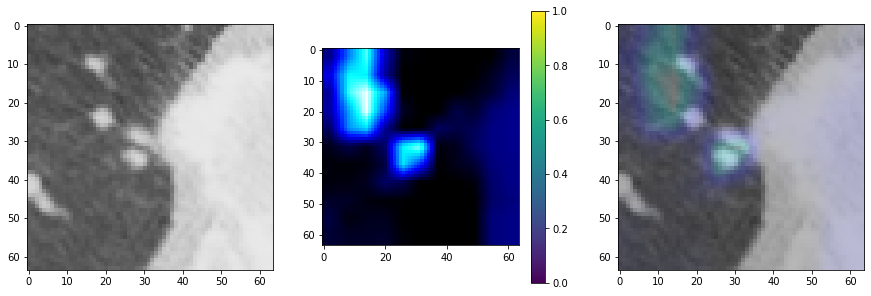

- Probabilidad clase maligna: 0.4421156
- Clase real: maligna






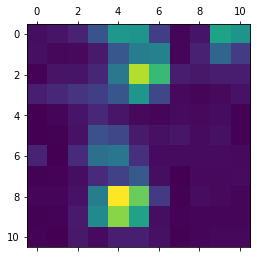

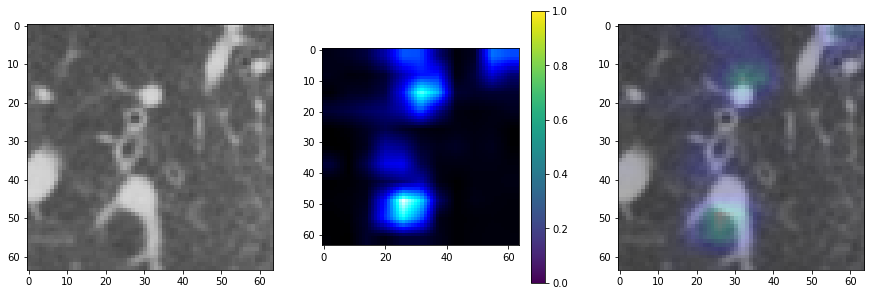

- Probabilidad clase maligna: 0.28142434
- Clase real: maligna






In [115]:
# clase maligna:

ind = 1500
for i in range(ind, ind+100, 10):
    heat_map, superimposed_img = show_heatmap(model, X_test[i], y_test[i,1])#zonas en las que se fija para decir que son benignas o malignas

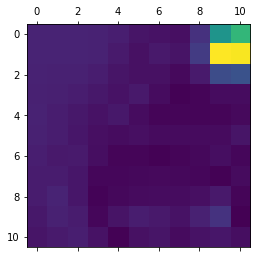

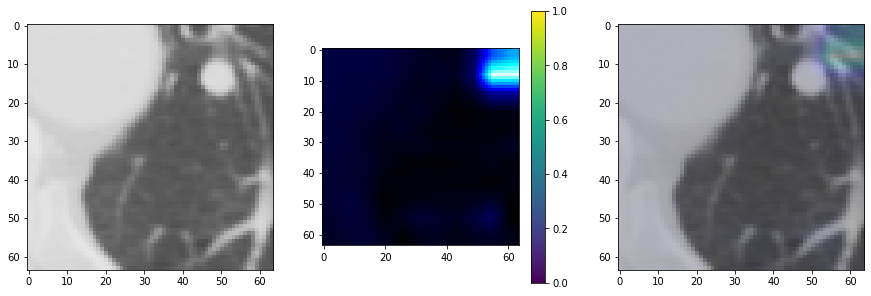

- Probabilidad clase maligna: 0.31340876
- Clase real: benigna






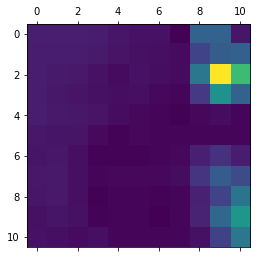

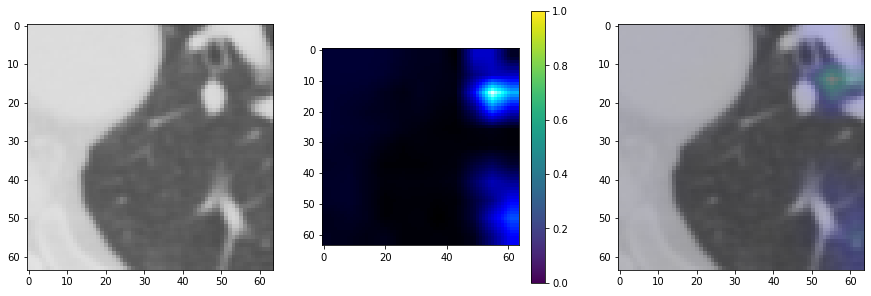

- Probabilidad clase maligna: 0.24362129
- Clase real: benigna






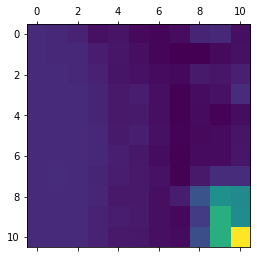

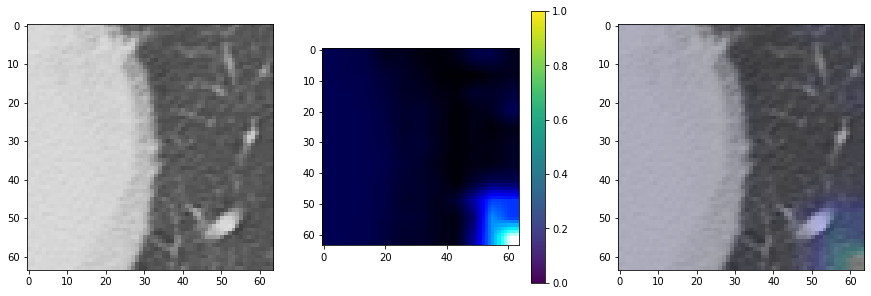

- Probabilidad clase maligna: 0.45798233
- Clase real: benigna






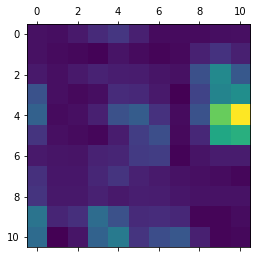

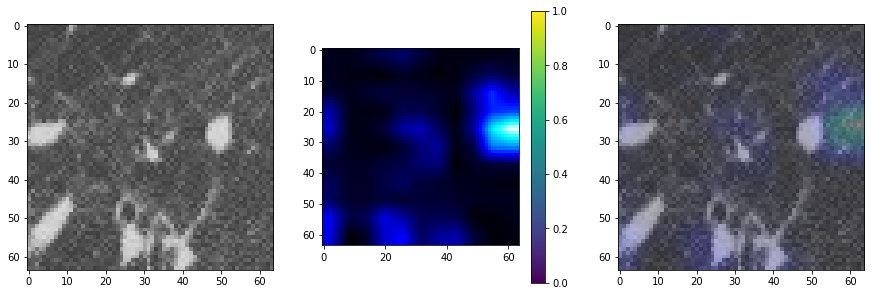

- Probabilidad clase maligna: 0.1509411
- Clase real: benigna






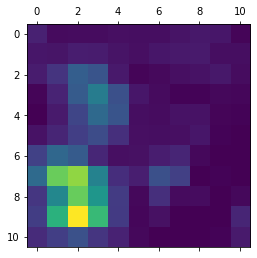

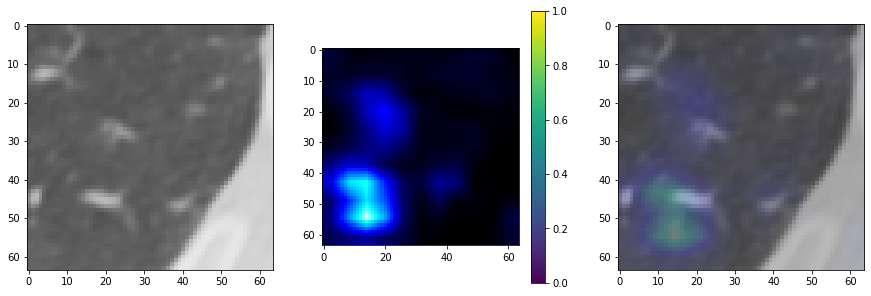

- Probabilidad clase maligna: 0.39233
- Clase real: benigna






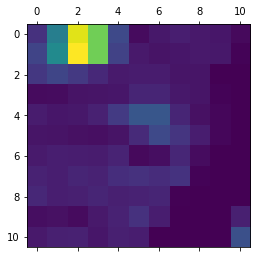

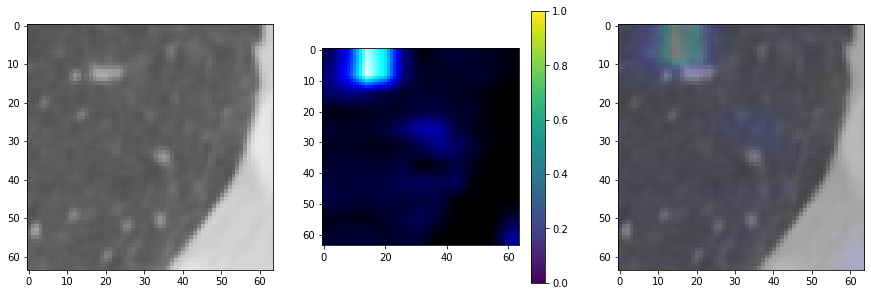

- Probabilidad clase maligna: 0.46591347
- Clase real: benigna






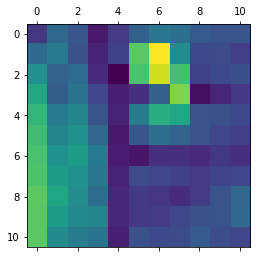

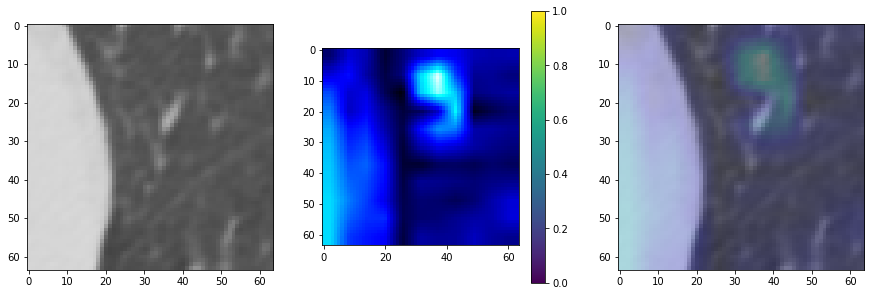

- Probabilidad clase maligna: 0.49907398
- Clase real: benigna






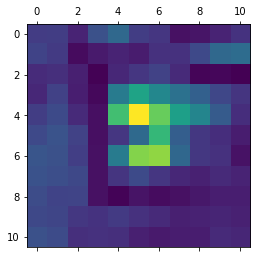

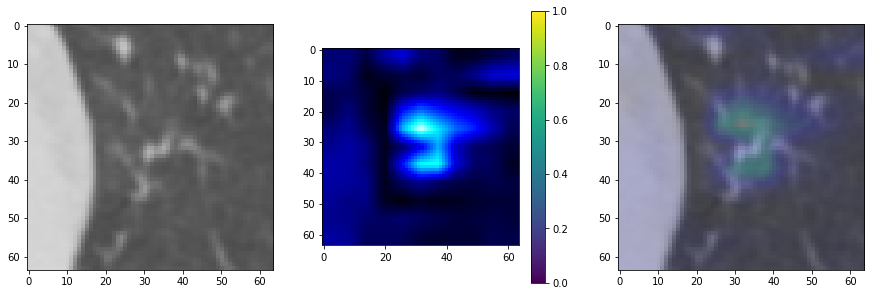

- Probabilidad clase maligna: 0.4562132
- Clase real: benigna






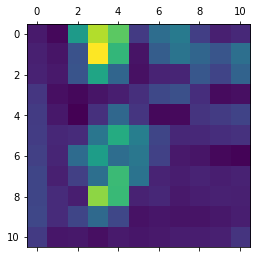

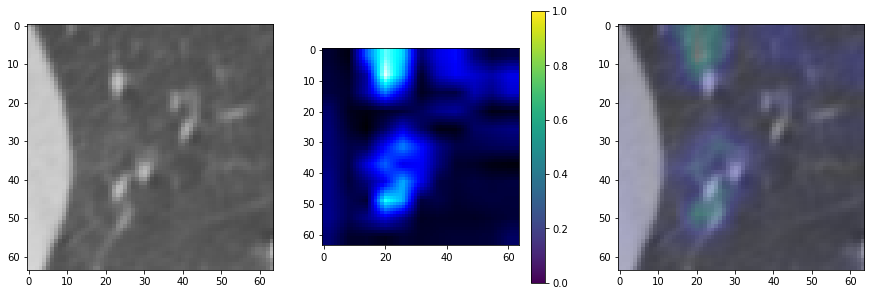

- Probabilidad clase maligna: 0.42156535
- Clase real: benigna






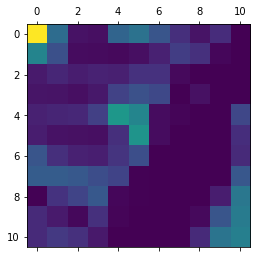

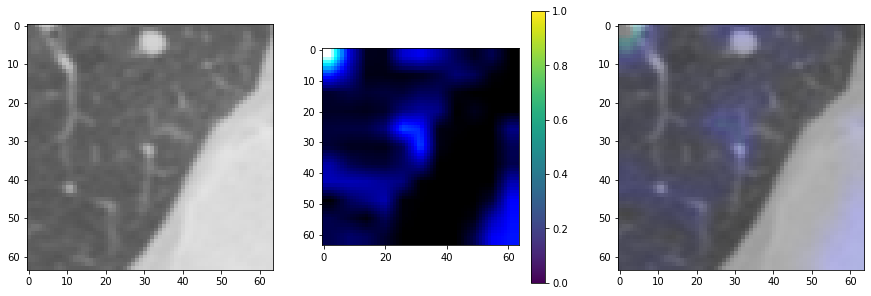

- Probabilidad clase maligna: 0.5384977
- Clase real: benigna






In [116]:
# clase benigna:

ind = 0
for i in range(ind, ind+100, 10):
    heat_map, superimposed_img = show_heatmap(model, X_test[i], y_test[i,1])